# **Regresión Dinámica Inversa para doble péndulo**

In [32]:
import math
import numpy as np
import tensorflow as tf
import keras 
import pandas as pd
#from tensorflow import keras
from keras.models import Sequential #One of the most important classes in tensorflow, used to creare NN (Named after NN as a sequence of layers)
from keras.layers import Dense, LSTM, BatchNormalization, Dropout #Dense layer means that one neuron in one layer is connected to all neurons in the next layer
from keras.regularizers import l2, l1, l1_l2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import shuffle
import pandas as pd
import matplotlib.pyplot as plt


In [33]:
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

In [34]:
model_name = "dp_backDyn_FF"     # val_loss=0.0016, 80 épocas, 50 mil muestras random
model_name = "dp_backDyn_FF_1"   # val_loss=0.0009, 171 épocas, 50 mil muestras random
fileNameScalers = f'/content/drive/My Drive/Colab Notebooks/{model_name}_scalers.pkl'
fileNameModel = f'/content/drive/My Drive/Colab Notebooks/{model_name}_.h5'

In [35]:
datos_2LRP_random = pd.read_csv(f'./2lpr_randomsamples_2025_05_13-23_28_07.csv',delimiter=',', encoding="utf-8", skipinitialspace=True)
datos_2LRP_joint = pd.read_csv(f'./2lpr_jointmovement_2025_05_03-19_10_52.csv',delimiter=',', encoding="utf-8", skipinitialspace=True)
datos_2LRP_cart = pd.read_csv(f'./2lpr_cartesianmovement_2025_05_05-22_50_57.csv',delimiter=',', encoding="utf-8", skipinitialspace=True)

In [36]:
pos_j1 = datos_2LRP_random.iloc[:,1].values
pos_j2 = datos_2LRP_random.iloc[:,2].values

vels_j1 = datos_2LRP_random.iloc[:,3].values
vels_j2 = datos_2LRP_random.iloc[:,4].values

accs_j1 = datos_2LRP_random.iloc[:,5].values
accs_j2 = datos_2LRP_random.iloc[:,6].values

torq_j1 = datos_2LRP_random.iloc[:,7].values
torq_j2 = datos_2LRP_random.iloc[:,8].values

In [37]:
time_joint = datos_2LRP_joint.iloc[:,1].values

pos_j1_joint = datos_2LRP_joint.iloc[:,2].values
pos_j2_joint = datos_2LRP_joint.iloc[:,3].values

vels_j1_joint = datos_2LRP_joint.iloc[:,4].values
vels_j2_joint = datos_2LRP_joint.iloc[:,5].values

accs_j1_joint = datos_2LRP_joint.iloc[:,6].values
accs_j2_joint = datos_2LRP_joint.iloc[:,7].values

torq_j1_joint = datos_2LRP_joint.iloc[:,8].values
torq_j2_joint = datos_2LRP_joint.iloc[:,9].values

In [38]:
time_cart = datos_2LRP_cart.iloc[:,1].values

pos_j1_cart = datos_2LRP_cart.iloc[:,2].values
pos_j2_cart = datos_2LRP_cart.iloc[:,3].values

vels_j1_cart = datos_2LRP_cart.iloc[:,4].values
vels_j2_cart = datos_2LRP_cart.iloc[:,5].values

accs_j1_cart = datos_2LRP_cart.iloc[:,6].values
accs_j2_cart = datos_2LRP_cart.iloc[:,7].values

torq_j1_cart = datos_2LRP_cart.iloc[:,8].values
torq_j2_cart = datos_2LRP_cart.iloc[:,9].values

# **Red neuronal Secuencial (Same-step approach)**:

No es el entrenamiento de las redes lo que se compara, sino la calidad de los resultados finales. Cada red tiene una técnica de entrenamiento: las secuenciales no aprenden la correlación entre muestras, entonces es mejor entrenarlas con muestras descorrelacionadas -> ruido blanco, en cambio, las redes LSTM aprenden la historia y evolución del sistema (la correlación entre muestras), van a necesitar muestras ordenadas, secuencia de tiempo.

Problema Dinámico INVERSO: Dados las posiciones, velocidades y aceleraciones joint, obtener el valor de los torques necesarios para mantener esa posición.

En el método de same step approach, tengo que tener en cuenta cómo se describe la fórmula a analizar. Para el problema inverso, tengo en cuenta que la expresión de la dinámica es una función contínua, pero todo refiere al mismo instante de tiempo, ya que dadas las posiciones, velocidades y aceleraciones, el valor de torque obtenido es aquel para mantener esta posición. Entonces los valores de posición y velocidad son para el instante de tiempo del torque resultante. 

In [39]:
#inputs = np.vstack((pos_j1, pos_j2, vels_j1, vels_j2, accs_j1, accs_j2)).T
#outputs = np.vstack((torq_j1, torq_j2)).T
inputs = np.vstack((pos_j1_joint, pos_j2_joint, vels_j1_joint, vels_j2_joint, accs_j1_joint, accs_j2_joint)).T
outputs = np.vstack((torq_j1_joint, torq_j2_joint)).T

In [40]:
inputs.shape

(295903, 6)

In [41]:
# Defino el conjunto de datos que voy a usar para entrenar y el que voy a usar para validar (test) -> Porcentajes similares al usados en el paper
X_train_SS, X_test_SS, y_train_SS, y_test_SS = train_test_split(inputs, outputs, test_size = 0.20)
X_train_SS, X_val_SS, y_train_SS, y_val_SS = train_test_split(X_train_SS, y_train_SS, test_size=0.20)

In [42]:
X_train_SS.shape

(189377, 6)

In [43]:
X_test_SS.shape

(59181, 6)

In [44]:
X_val_SS.shape

(47345, 6)

In [45]:
#Tengo que hacer preprocesado de los datos para que los calculos no sean tan pesados
scaler1_SS = StandardScaler()
X_train_SS = scaler1_SS.fit_transform(X_train_SS)#Primero se llama a la funcion fit para que ajuste los datos
X_test_SS = scaler1_SS.transform(X_test_SS) #Una vez que los datos fueron ajustados se puede llamar a la transformacion directamente
X_val_SS = scaler1_SS.transform(X_val_SS)

#Lo mismo para los outputs
scaler2_SS = StandardScaler() #Otra forma de ESCALAR ---> scaler = StandardScaler()
y_train_SS = scaler2_SS.fit_transform(y_train_SS)
y_test_SS = scaler2_SS.transform(y_test_SS)
y_val_SS = scaler2_SS.transform(y_val_SS)

In [46]:
FFNN_SS_network = Sequential()
FFNN_SS_network.add(Dense(200,input_shape = (inputs.shape[1],), activation = 'tanh')) # 2x8x4x2
FFNN_SS_network.add(Dense(200, activation='tanh')) # 2x8x4
#FFNN_SS_network.add(Dense(100, activation='tanh'))
FFNN_SS_network.add(Dense(outputs.shape[1])) #2

FFNN_SS_network.summary()

/usr/local/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 200)            │         1,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 2)              │           402 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,002 (164.07 KB)

 Trainable params: 42,002 (164.07 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
FFNN_SS_network.compile(loss = 'mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics = ['mae'])#Que pasa si uso SGD con learning rate

In [48]:
#checkpoint_cb = keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/CT_p/2LPR/Modelos_NN/FF_NN_EPOCHS/ff_nn-{epoch:02d}.h5")
checkpoint_cb = keras.callbacks.ModelCheckpoint("./2LPR/ID_NN/Modelos_NN/FF_NN/FF_NN_nn_Best_Model.keras", save_best_only=True)
#checkpoint_cb = keras.callbacks.ModelCheckpoint("./ID_NN/Modelos_NN/FF_NN_EPOCHS/ff_nn-{epoch:02d}.keras")
early_stopping_cb = keras.callbacks.EarlyStopping(patience=200,  min_delta=1E-10, restore_best_weights=True)

In [49]:
FFNN_SS_history = FFNN_SS_network.fit(X_train_SS, y_train_SS, batch_size=300, epochs=2000, validation_data=(X_val_SS, y_val_SS), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/2000
 61/632 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.6266 - mae: 0.6510

KeyboardInterrupt: 

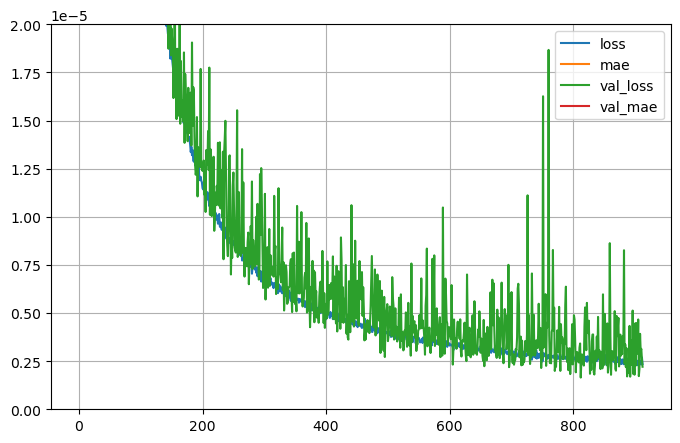

In [ ]:
pd.DataFrame(FFNN_SS_history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 2e-5)
plt.show()

In [ ]:
accuracy_test_SS = FFNN_SS_network.evaluate(X_test_SS, y_test_SS)

1850/1850 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.6427e-06 - mae: 9.5181e-04


In [ ]:
predictions_SS = FFNN_SS_network.predict(X_test_SS)

1850/1850 ━━━━━━━━━━━━━━━━━━━━ 2s 876us/step


In [ ]:
predictions_SS[0]

array([-1.6720889, -1.0108055], dtype=float32)

In [ ]:
y_test_SS[0]

array([-1.67187553, -1.0115609 ])

# **Red neuronal Secuencial (One-step-ahead approach)**

¿Es válido hacer un análisis One Step Ahead si el problema dinámico inverso se plantea como dadas las posiciones, velocidades y aceleraciones joint, obtener el valor de los torques necesarios para mantener esa posición?

Para el análisis con los datos randomizados, no tengo una secuencialidad de los datos ya que cada muestra es randomizada. Voy a probarlo con otro conjunto de muestras, pero inicialmente, creería que para resolver el problema dinámico no tiene sentido utilizar este método.

# **Red neuronal LSTM**

En primer lugar, voy a probar el entrenamiento con movimiento joint

In [ ]:
def create_lstm_sequences(inputs, outputs, time_joint, window_size=50, split=0.8):
    """
    Genera secuencias de entrada y salida para una LSTM a partir de los datos de posición, velocidad, aceleración y torque.
    
    Args:
        inputs: Matriz de entrada que contiene las posiciones, velocidades y aceleraciones.
        outputs: Matriz de salida que contiene los torques.
        time_joint: Vector de tiempo asociado a los datos.
        window_size: Tamaño de la ventana de tiempo para la LSTM.
        split: Proporción del dataset que se utiliza para entrenamiento (el resto para prueba).
        
    Returns:
        X_train: Secuencias de entrada para entrenamiento.
        Y_train: Secuencias de salida para entrenamiento.
        X_test: Secuencias de entrada para prueba.
        Y_test: Secuencias de salida para prueba.
        t_test: Vector de tiempo correspondiente al conjunto de prueba.
    """
    # Preparar las secuencias de entrada y salida usando ventanas deslizantes
    input_sequences = []
    output_sequences = []
    
    for i in range(len(inputs) - window_size):
        input_sequences.append(inputs[i:i+window_size])
        output_sequences.append(outputs[i+window_size])
    
    # Convertir a arrays numpy
    X = np.array(input_sequences)
    Y = np.array(output_sequences)
    
    # Dividir en conjuntos de entrenamiento y prueba
    if split > 0 and split < 1:
        idx_split = int(split * len(X))
        X_train, X_test = X[:idx_split], X[idx_split:]
        Y_train, Y_test = Y[:idx_split], Y[idx_split:]
        t_test = time_joint[idx_split:len(inputs) - window_size]
    else:
        X_train, X_test = X, None
        Y_train, Y_test = Y, None
        t_test = time_joint[:len(inputs) - window_size]
    
    return X_train, Y_train, X_test, Y_test, t_test


In [ ]:
#Inputs ---> uk=[qTk-1  d_qTk-1  tauTk]T
time_joint = datos_2LRP_joint.iloc[:,1].values  

pos_j1_joint = datos_2LRP_joint.iloc[:,2].values
pos_j2_joint = datos_2LRP_joint.iloc[:,3].values

vels_j1_joint = datos_2LRP_joint.iloc[:,4].values
vels_j2_joint = datos_2LRP_joint.iloc[:,5].values

accs_j1_joint = datos_2LRP_joint.iloc[:,6].values
accs_j2_joint = datos_2LRP_joint.iloc[:,7].values

torq_j1_joint = datos_2LRP_joint.iloc[:,8].values
torq_j2_joint = datos_2LRP_joint.iloc[:,9].values

In [ ]:
inputs_joint = np.vstack((pos_j1_joint, pos_j2_joint, vels_j1_joint, vels_j2_joint, accs_j1_joint, accs_j2_joint)).T
outputs_joint = np.vstack((torq_j1_joint, torq_j2_joint)).T

In [ ]:
#Para las LSTM es necesario que defin
# N_segments = 50 #Puntos destino de movimiento joint

# Definir el tamaño de la ventana de tiempo para las secuencias
w_size = 2

# Preprocesar (escalar) los inputs y outputs antes de crear las secuencias
scaler1_LSTM = StandardScaler() #StandardScaler() #StandardScaler()
inputs_joint = scaler1_LSTM.fit_transform(inputs_joint)

scaler2_LSTM = StandardScaler() #StandardScaler() #StandardScaler()
outputs_joint = scaler2_LSTM.fit_transform(outputs_joint)

X_train_LSTM, y_train_LSTM, X_test_LSTM, y_test_LSTM, t_test_LSTM  = create_lstm_sequences(inputs_joint, outputs_joint, time_joint, window_size=w_size, split=0.8)

In [ ]:
print(X_train_LSTM.shape)  # Verifica el tamaño de las muestras
print(y_train_LSTM.shape)  # Verifica el tamaño de las etiquetas


(236720, 2, 6)
(236720, 2)


In [ ]:
LSTM_network = Sequential()
LSTM_network.add(LSTM(100, dropout=0, input_shape=(w_size, X_train_LSTM.shape[2]), activation='tanh'))
#LSTM_network.add(LSTM(50, dropout=0, input_shape=(w_size, X_train_LSTM.shape[2]), activation='tanh', return_sequences=True))
#LSTM_network.add(LSTM(10, dropout=0, activation='tanh', return_sequences=True))
#LSTM_network.add(LSTM(10, dropout=0, activation='tanh', return_sequences=True))
#LSTM_network.add(LSTM(50, dropout=0, activation='tanh'))
LSTM_network.add(Dense(y_train_LSTM.shape[1]))
# Compile the model
LSTM_network.compile(loss = 'mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate=1e-4), metrics = ['mae'])
LSTM_network.summary()

/usr/local/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100)            │        42,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,002 (167.98 KB)

 Trainable params: 43,002 (167.98 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
LSTM_checkpoint_cb = keras.callbacks.ModelCheckpoint("./2LPR/ID_NN/Modelos_NN/LSTM/LSTM_nn_Best_Model.keras", save_best_only=True)
#LSTM_checkpoint_cb = keras.callbacks.ModelCheckpoint("./ID_NN/Modelos_NN/LINEAR/LSTM_nn_Best_Model.keras",save_best_only=True)
LSTM_early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, min_delta=1E-10, restore_best_weights=True)
#Para el caso de Joint el min_delta parece ser muy bajo -> mentira, no estaba escalando bien los datos

In [ ]:
LSTM_history = LSTM_network.fit(X_train_LSTM, y_train_LSTM, epochs=500, batch_size=64, callbacks=[LSTM_checkpoint_cb, LSTM_early_stopping_cb], validation_data=(X_test_LSTM, y_test_LSTM))

Epoch 1/500
3699/3699 ━━━━━━━━━━━━━━━━━━━━ 31s 8ms/step - loss: 0.3938 - mae: 0.4820 - val_loss: 0.0332 - val_mae: 0.1410
Epoch 2/500
3699/3699 ━━━━━━━━━━━━━━━━━━━━ 30s 8ms/step - loss: 0.0255 - mae: 0.1113 - val_loss: 0.0085 - val_mae: 0.0648
Epoch 3/500
3699/3699 ━━━━━━━━━━━━━━━━━━━━ 33s 9ms/step - loss: 0.0055 - mae: 0.0527 - val_loss: 0.0036 - val_mae: 0.0392
Epoch 4/500
3699/3699 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - loss: 0.0022 - mae: 0.0326 - val_loss: 0.0020 - val_mae: 0.0286
Epoch 5/500
3699/3699 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - loss: 0.0013 - mae: 0.0241 - val_loss: 0.0014 - val_mae: 0.0231
Epoch 6/500
3699/3699 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 8.4748e-04 - mae: 0.0190 - val_loss: 0.0010 - val_mae: 0.0194
Epoch 7/500
3699/3699 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - loss: 6.3574e-04 - mae: 0.0157 - val_loss: 8.3607e-04 - val_mae: 0.0172
Epoch 8/500
3699/3699 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 4.9355e-04 - mae: 0.0133 - val_loss: 7.4587e-04 - val_mae: 0.0159
Epoc

KeyboardInterrupt: 

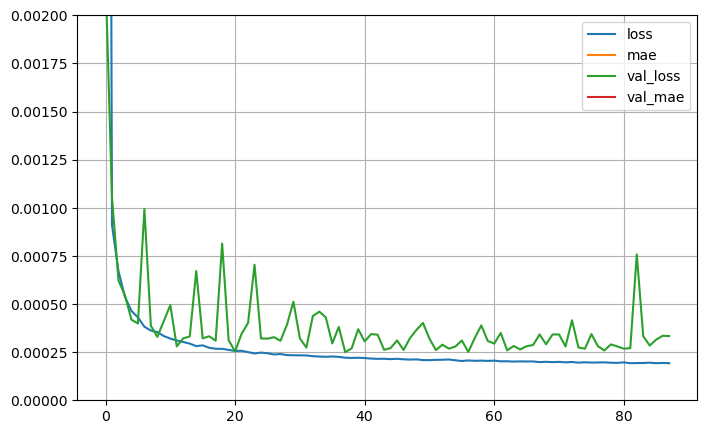

In [ ]:
pd.DataFrame(LSTM_history.history).plot(figsize=(8, 5))
plt.grid(True)
#plt.gca().set_xlim(0, 1)
plt.gca().set_ylim(0, 2e-3)
plt.show()

In [ ]:
LSTM_accuracy_test = LSTM_network.evaluate(X_test_LSTM, y_test_LSTM)

1850/1850 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 2.1731e-04 - mae: 0.0051


In [ ]:
predictions_LSTM = LSTM_network.predict(X_test_LSTM)

1850/1850 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step


In [ ]:
predictions_LSTM[0]

array([1.7179548, 2.7680063], dtype=float32)

In [ ]:
y_test_LSTM[0]

array([1.71372501, 2.75992801])

# **Comparación de Modelos NN con otro conjunto de datos**

La comparación de los modelos 

In [ ]:
#Uso el otro dataset joint

datos_2LRP_ref_joint = pd.read_csv(f'./2lpr_jointmovement_2024_10_15-00_36_00.csv',delimiter=',', encoding="utf-8", skipinitialspace=True)
#datos_2LRP_ref_joint.head()
t_ref = datos_2LRP_ref_joint.iloc[:,1].values

q1_ref = datos_2LRP_ref_joint.iloc[:,2].values
q2_ref = datos_2LRP_ref_joint.iloc[:,3].values

dq1_ref = datos_2LRP_ref_joint.iloc[:,4].values
dq2_ref = datos_2LRP_ref_joint.iloc[:,5].values

ddq1_ref = datos_2LRP_ref_joint.iloc[:,6].values
ddq2_ref = datos_2LRP_ref_joint.iloc[:,7].values

t1_ref = datos_2LRP_ref_joint.iloc[:,8].values
t2_ref = datos_2LRP_ref_joint.iloc[:,9].values
datos_2LRP_ref_joint.head()

,ID,Time,Theta_1,Theta_2,D_Theta_1,D_Theta_2,DD_Theta_1,DD_Theta_2,Torque_1,Torque_2
0,1,0.000,-1.926178,-1.430799,0.001258,0.004265,1.257762,4.265447,-2.000074,-0.890958
1,2,0.001,-1.926176,-1.430793,0.002516,0.008531,1.257762,4.265447,-1.999438,-0.888827
2,3,0.002,-1.926173,-1.430782,0.003773,0.012796,1.257762,4.265447,-1.998798,-0.886697
3,4,0.003,-1.926168,-1.430767,0.005031,0.017062,1.257762,4.265447,-1.998153,-0.884568
4,5,0.004,-1.926163,-1.430748,0.006289,0.021327,1.257762,4.265447,-1.997503,-0.882441


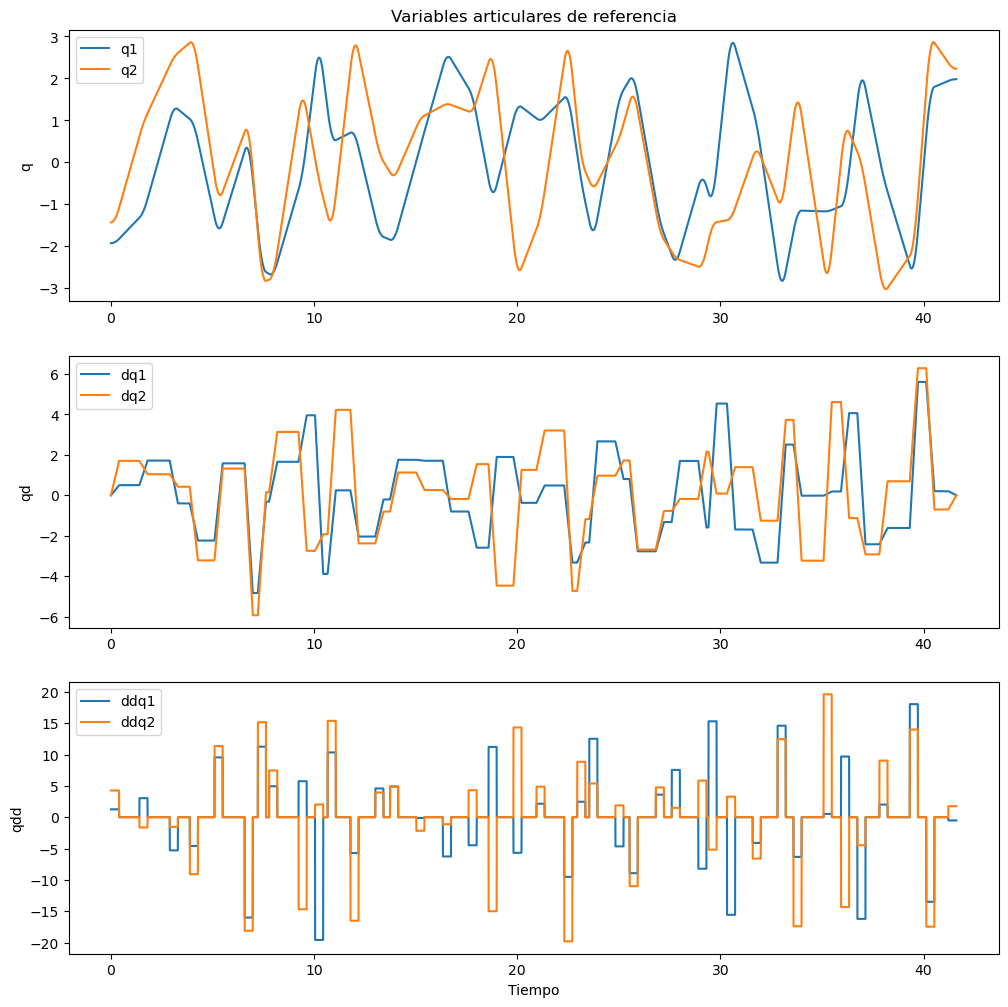

In [ ]:
num_links = 2

plt.figure(figsize=(12, 12))
plt.subplot(3,1,1)
plt.plot(t_ref, q1_ref, label='q1')
plt.plot(t_ref, q2_ref, label='q2')
plt.legend();  plt.ylabel('q')
plt.title('Variables articulares de referencia')
plt.subplot(3,1,2)
plt.plot(t_ref, dq1_ref, label='dq1')
plt.plot(t_ref, dq2_ref, label='dq2')
plt.legend();  plt.ylabel('qd')
plt.subplot(3,1,3)
plt.plot(t_ref, ddq1_ref, label='ddq1')
plt.plot(t_ref, ddq2_ref, label='ddq2')
plt.legend(); plt.xlabel('Tiempo'); plt.ylabel('qdd')
plt.show()


In [ ]:
inputs_ref = np.vstack((q1_ref,q2_ref,dq1_ref,dq2_ref,ddq1_ref,ddq2_ref)).T
outputs_ref = np.vstack((t1_ref,t2_ref)).T

In [ ]:
#Primero con FF NN

X_test_scaled_FF_NN = scaler1_SS.transform(inputs_ref)
tau_sim_FF_NN = scaler2_SS.inverse_transform(FFNN_SS_network.predict(X_test_scaled_FF_NN))

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 1s 866us/step


In [ ]:
#Ahora con LSTM

def create_sequences_with_time(data, time, window_size= w_size):
    sequences = []
    times = []
    
    for i in range(len(data) - window_size + 1):
        sequence = data[i:i + window_size]
        sequences.append(sequence)
        
        # Obtener el tiempo correspondiente al centro de la ventana
        time_center = time[i + window_size // 2]  # Usa el centro de la ventana
        times.append(time_center)
    
    return np.array(sequences), np.array(times)

X_test_scaled_LSTM = scaler1_LSTM.transform(inputs_ref)
X_test_windowed_LSTM, t_ref_LSTM = create_sequences_with_time(X_test_scaled_LSTM, t_ref)
tau_sim_LSTM = scaler2_LSTM.inverse_transform(LSTM_network.predict(X_test_windowed_LSTM))

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


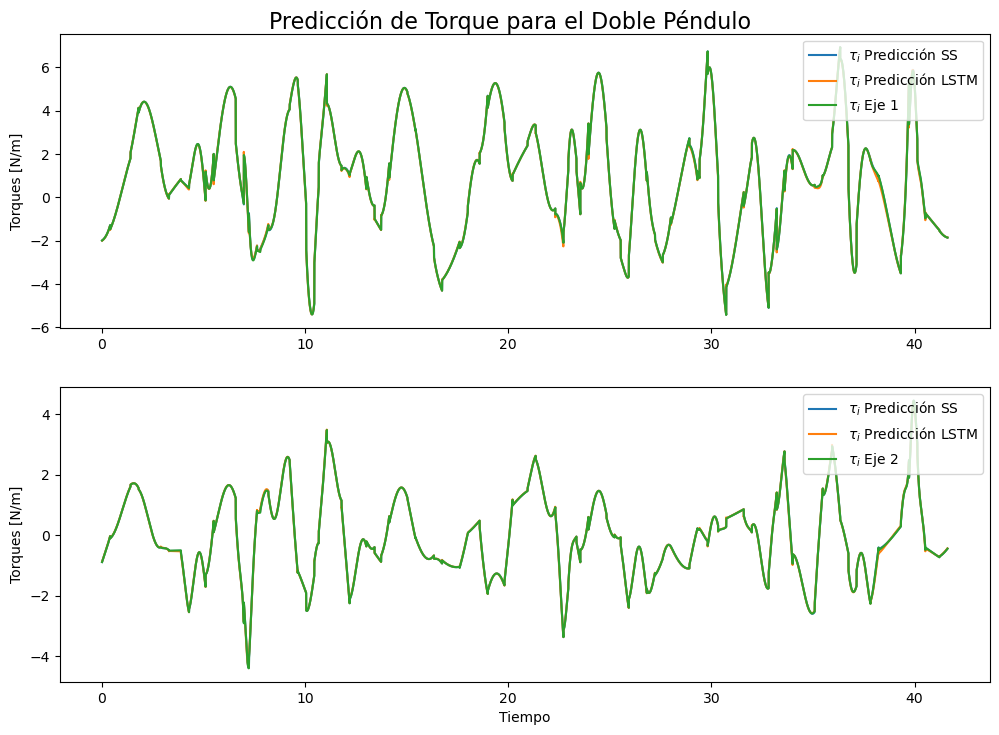

In [ ]:
plt.figure(figsize=(12, 8)) 

# Agregar un título general
plt.suptitle("Predicción de Torque para el Doble Péndulo", fontsize=16, y=0.95)

# Grafico los resultados
for i in range(num_links):
  plt.subplot(num_links, 1, i+1)
  plt.plot(t_ref,tau_sim_FF_NN[:,i])
  plt.plot(t_ref_LSTM,tau_sim_LSTM[:,i])
  plt.plot(t_ref,outputs_ref[:,i])
  plt.legend([r"$\tau_{i}$ Predicción SS", r"$\tau_{i}$ Predicción LSTM", r"$\tau_{i}$ " f'Eje {i+1}'],loc='upper right', fontsize=10)
  plt.ylabel('Torques [N/m]')

plt.subplots_adjust(top=0.92)  
plt.xlabel('Tiempo');
plt.show()

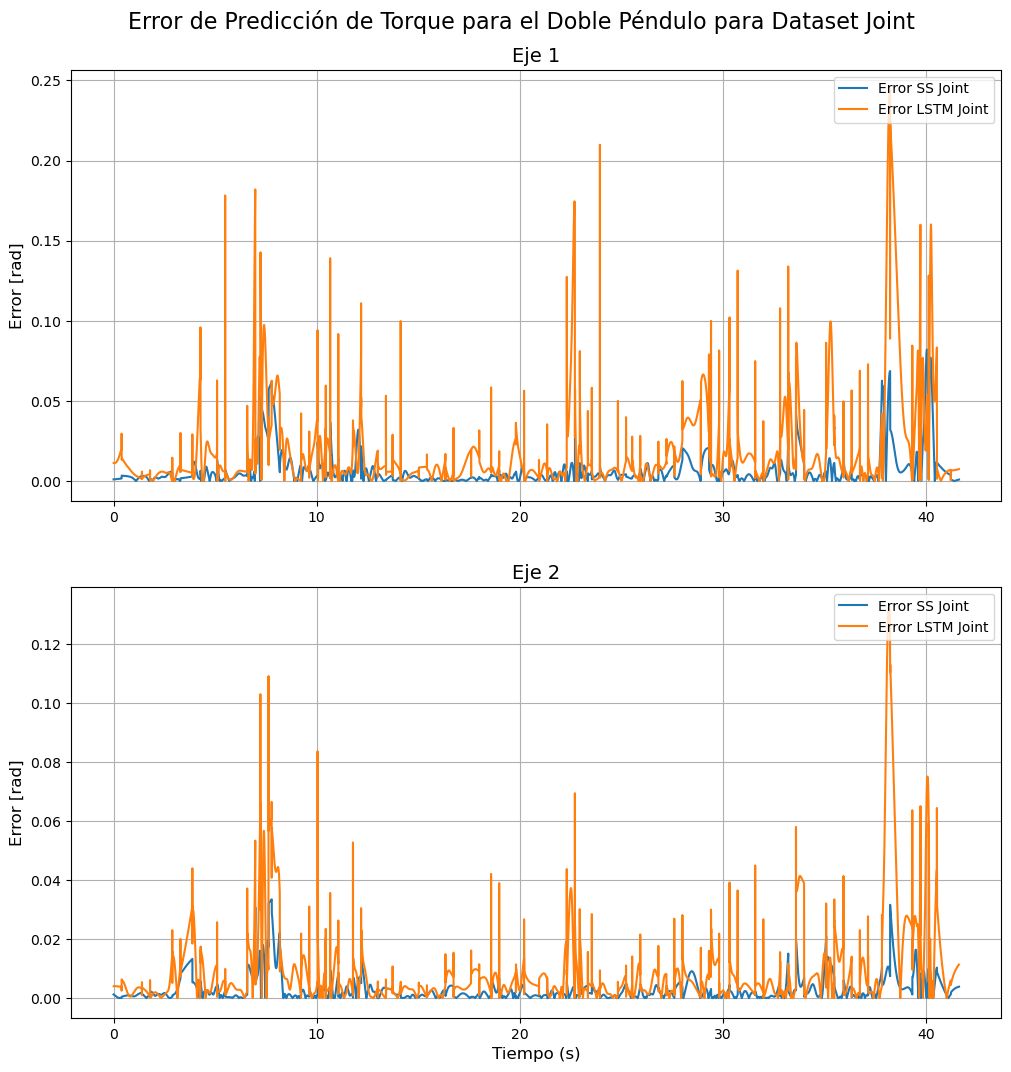

In [ ]:
# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 12))  # Cambia el tamaño según tus necesidades

# Agregar un título general
plt.suptitle("Error de Predicción de Torque para el Doble Péndulo para Dataset Joint", fontsize=16,  y=0.95)

# Graficar los errores
for i in range(num_links):
    plt.subplot(num_links, 1, i + 1)

    error_OSA_Joint_j = np.sqrt((tau_sim_FF_NN[:, i] - outputs_ref[:, i])**2)
    error_LSTM_Joint_j = np.sqrt((tau_sim_LSTM[:, i] - outputs_ref[w_size-1:, i])**2)
    
    # Graficar los errores
    plt.plot(t_ref, error_OSA_Joint_j, label='Error SS Joint')
    plt.plot(t_ref_LSTM, error_LSTM_Joint_j, label='Error LSTM Joint')
    
    # Ajustar etiquetas y título del subplot
    plt.ylabel(r'Error [rad]', fontsize=12)
    plt.title(f'Eje {i+1}', fontsize=14)
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True)  # Añadir una cuadrícula para facilitar la lectura

# Etiqueta para el eje X
plt.xlabel('Tiempo (s)', fontsize=12)

plt.subplots_adjust(top=0.90)  

# Ajustar los espacios entre subplots
#plt.tight_layout(rect=[0, 0, 1, 0.95])  # Dejar espacio para el título general

# Mostrar el gráfico
plt.show()


# **Comparación de métricas de los modelos**

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def compare_models(model1, model2, model1_name, model2_name, X_test1, y_test1, X_test2, y_test2):
    # Hacer predicciones para cada modelo en su propio conjunto de datos
    y_pred_model1 = model1.predict(X_test1)
    y_pred_model2 = model2.predict(X_test2)

    # Calcular métricas para model1 en su dataset
    mse_model1 = mean_squared_error(y_test1, y_pred_model1)
    mae_model1 = mean_absolute_error(y_test1, y_pred_model1)
    r2_model1 = r2_score(y_test1, y_pred_model1)

    # Calcular métricas para model2 en su dataset
    mse_model2 = mean_squared_error(y_test2, y_pred_model2)
    mae_model2 = mean_absolute_error(y_test2, y_pred_model2)
    r2_model2 = r2_score(y_test2, y_pred_model2)

    # Mostrar métricas para cada dataset
    print(f"Métricas del {model1_name} (Dataset 1):")
    print(f"MSE: {mse_model1:.4f}")
    print(f"MAE: {mae_model1:.4f}")
    print(f"R²: {r2_model1:.4f}")

    print(f"\nMétricas del {model2_name} (Dataset 2):")
    print(f"MSE: {mse_model2:.4f}")
    print(f"MAE: {mae_model2:.4f}")
    print(f"R²: {r2_model2:.4f}")

    # Opcional: Normalizar métricas (normalización simple usando el rango de los valores reales)
    range_y_test1 = np.max(y_test1) - np.min(y_test1)
    range_y_test2 = np.max(y_test2) - np.min(y_test2)

    mse_model1_normalized = mse_model1 / range_y_test1
    mse_model2_normalized = mse_model2 / range_y_test2

    print(f"\nMSE Normalizado para {model1_name}: {mse_model1_normalized:.4f}")
    print(f"MSE Normalizado para {model2_name}: {mse_model2_normalized:.4f}")

# Graficar curvas de pérdida durante el entrenamiento si tienes los históricos de entrenamiento
def plot_loss_curve(history1, model_name1, history2, model_name2):
    plt.plot(history1.history['loss'], label=f'Pérdida Entrenamiento {model_name1}')
    plt.plot(history1.history['val_loss'], label=f'Pérdida Validación {model_name1}')
    plt.plot(history2.history['loss'], label=f'Pérdida Entrenamiento {model_name2}')
    plt.plot(history2.history['val_loss'], label=f'Pérdida Validación {model_name2}')
    plt.title('Curvas de Pérdida')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.gca().set_ylim(0, 0.01)
    plt.legend()
    plt.show()


1388/1388 ━━━━━━━━━━━━━━━━━━━━ 1s 594us/step
1850/1850 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Métricas del Modelo SS (Dataset 1):
MSE: 0.0000
MAE: 0.0010
R²: 1.0000

Métricas del Modelo LSTM (Dataset 2):
MSE: 0.0002
MAE: 0.0055
R²: 0.9997

MSE Normalizado para Modelo SS: 0.0000
MSE Normalizado para Modelo LSTM: 0.0000


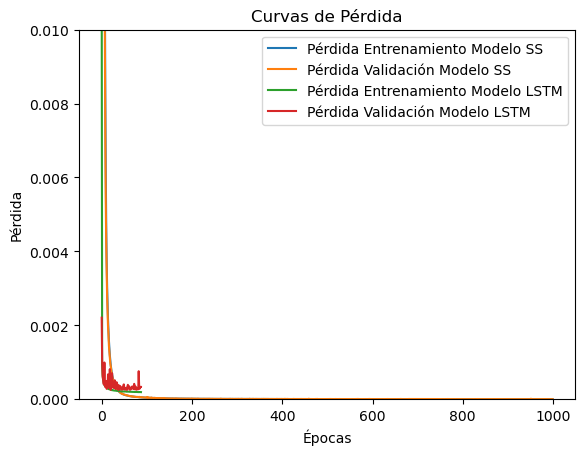

In [ ]:
compare_models(FFNN_SS_network, LSTM_network,'Modelo SS', 'Modelo LSTM', X_test_SS, y_test_SS, X_test_LSTM, y_test_LSTM)
plot_loss_curve(FFNN_SS_history , 'Modelo SS', LSTM_history, 'Modelo LSTM')

# **Comparación de conjunto de Datos, Cartesiano vs Joint**

Para la comparación entre el conjunto de datos Cartesiano vs Joint, voy a crear otras redes neuronales FF y LSTM con las mismas características que las anteriores, entrenándolas exclusivamente con datasets cartesianos, y se compara la estimación de las 4 redes utilizando un nuevo conjunto joint y un nuevo conjunto cartesiano.

# Empiezo por el caso FeedForward

In [ ]:
inputs_cart = np.vstack((pos_j1_cart, pos_j2_cart, vels_j1_cart, vels_j2_cart, accs_j1_cart, accs_j2_cart)).T
outputs_cart = np.vstack((torq_j1_cart, torq_j2_cart)).T

In [ ]:
#Preparo los datos para la red FF
X_train_FF_cart, X_test_FF_cart, y_train_FF_cart, y_test_FF_cart = train_test_split(inputs_cart, outputs_cart, test_size = 0.15)
X_train_FF_cart, X_val_FF_cart, y_train_FF_cart, y_val_FF_cart = train_test_split(X_train_FF_cart, y_train_FF_cart, test_size=0.15)

In [ ]:
#Tengo que hacer preprocesado de los datos para que los calculos no sean tan pesados
scaler1_FF_cart = StandardScaler()
X_train_FF_cart = scaler1_FF_cart.fit_transform(X_train_FF_cart)#Primero se llama a la funcion fit para que ajuste los datos
X_test_FF_cart = scaler1_FF_cart.transform(X_test_FF_cart) #Una vez que los datos fueron ajustados se puede llamar a la transformacion directamente
X_val_FF_cart = scaler1_FF_cart.transform(X_val_FF_cart)

#Lo mismo para los outputs
scaler2_FF_cart = StandardScaler() #Otra forma de ESCALAR ---> scaler = StandardScaler()
y_train_FF_cart = scaler2_FF_cart.fit_transform(y_train_FF_cart)
y_test_FF_cart = scaler2_FF_cart.transform(y_test_FF_cart)
y_val_FF_cart = scaler2_FF_cart.transform(y_val_FF_cart)

In [ ]:
FFNN_network_cart = Sequential()
FFNN_network_cart.add(Dense(150, input_shape = (inputs.shape[1],), activation = 'tanh')) # 2x8x4x2
FFNN_network_cart.add(Dense(70, activation='tanh')) # 2x8x4
FFNN_network_cart.add(Dense(2)) #2
FFNN_network_cart.summary()
FFNN_network_cart.compile(loss = 'mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate=1e-4), metrics = ['mae'])

/usr/local/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 150)            │         1,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 70)             │        10,570 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 2)              │           142 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,762 (45.95 KB)

 Trainable params: 11,762 (45.95 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
checkpoint_cb_cart = keras.callbacks.ModelCheckpoint("./2LPR/ID_NN/Modelos_NN/FF_NN_cart/FF_NN_nn_Best_Model.keras", save_best_only=True)
early_stopping_cb_cart = keras.callbacks.EarlyStopping(patience=30, restore_best_weights=True)

In [ ]:
FFNN_history_cart = FFNN_network_cart.fit(X_train_FF_cart, y_train_FF_cart, batch_size=64, epochs=500, validation_data=(X_val_FF_cart, y_val_FF_cart), callbacks=[checkpoint_cb_cart, early_stopping_cb_cart])

Epoch 1/500
442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4703 - mae: 0.4878 - val_loss: 0.1385 - val_mae: 0.2865
Epoch 2/500
442/442 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1354 - mae: 0.2791 - val_loss: 0.1111 - val_mae: 0.2581
Epoch 3/500
442/442 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1044 - mae: 0.2467 - val_loss: 0.0680 - val_mae: 0.2060
Epoch 4/500
442/442 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0596 - mae: 0.1875 - val_loss: 0.0305 - val_mae: 0.1350
Epoch 5/500
442/442 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0276 - mae: 0.1229 - val_loss: 0.0166 - val_mae: 0.0957
Epoch 6/500
442/442 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0149 - mae: 0.0879 - val_loss: 0.0113 - val_mae: 0.0778
Epoch 7/500
442/442 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0111 - mae: 0.0720 - val_loss: 0.0082 - val_mae: 0.0644
Epoch 8/500
442/442 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0082 - mae: 0.0616 - val_loss: 0.0068 - val_mae: 0.0583
Epoch 9/500
442/442 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/

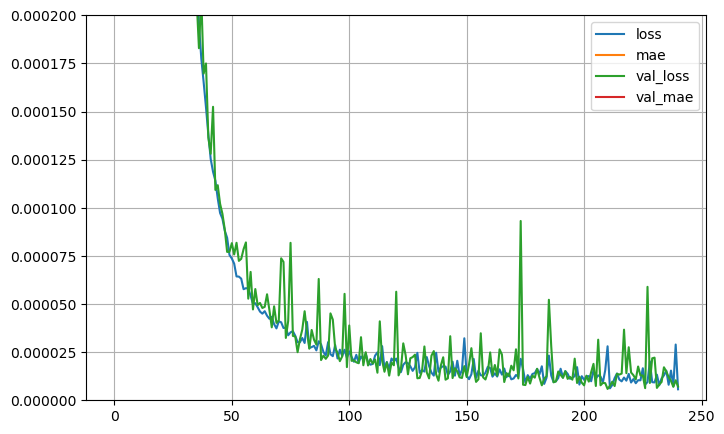

In [ ]:
pd.DataFrame(FFNN_history_cart.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 2e-4)
plt.show()

# Caso LSTM

In [ ]:
inputs_LSTM_cart = np.vstack((pos_j1_cart, pos_j2_cart, vels_j1_cart, vels_j2_cart, accs_j1_cart, accs_j2_cart)).T
outputs_LSTM_cart = np.vstack((torq_j1_cart, torq_j2_cart)).T

In [ ]:
# Definir el tamaño de la ventana de tiempo para las secuencias
w_size = 6

# Preprocesar (escalar) los inputs y outputs antes de crear las secuencias
scaler1_LSTM_cart = StandardScaler()
inputs_LSTM_cart = scaler1_LSTM_cart.fit_transform(inputs_LSTM_cart)

scaler2_LSTM_cart = StandardScaler()
outputs_LSTM_cart = scaler2_LSTM_cart.fit_transform(outputs_LSTM_cart)

X_train_LSTM_cart, y_train_LSTM_cart, X_test_LSTM_cart, y_test_LSTM_cart, t_test_LSTM_cart  = create_lstm_sequences(inputs_LSTM_cart, outputs_LSTM_cart, time_cart, window_size=w_size, split=0.8)

In [ ]:
LSTM_network_cart = Sequential()
LSTM_network_cart.add(LSTM(40, dropout=0, input_shape=(w_size, X_train_LSTM.shape[2]), activation='tanh', return_sequences=True))#, kernel_regularizer=l2(0.005)))
LSTM_network_cart.add(LSTM(10, dropout=0, activation='tanh'))
LSTM_network_cart.add(Dense(y_train_LSTM.shape[1]))
LSTM_network_cart.compile(loss = 'mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate=1e-4), metrics = ['mae'])
LSTM_network_cart.summary()

/usr/local/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 6, 40)          │         7,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 10)             │         2,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,582 (37.43 KB)

 Trainable params: 9,582 (37.43 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#LSTM_network_cart = Sequential()
#LSTM_network_cart.add(LSTM(units=35, dropout=0.15, input_shape=(w_size, X_train_LSTM.shape[2]), activation='tanh', return_sequences=True))#, kernel_regularizer=l2(0.005)))
#LSTM_network_cart.add(LSTM(35, dropout=0.05, activation='tanh'))
#LSTM_network_cart.add(Dense(y_train_LSTM.shape[1]))
#LSTM_network_cart.compile(loss = 'mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate=7e-6), metrics = ['mae'])
#LSTM_network_cart.summary()

In [ ]:
LSTM_checkpoint_cb_cart = keras.callbacks.ModelCheckpoint("./ID_NN/Modelos_NN/LSTM_cart/LSTM_nn_Best_Model.keras", save_best_only=True)
#LSTM_checkpoint_cb = keras.callbacks.ModelCheckpoint("./ID_NN/Modelos_NN/LINEAR/LSTM_nn_Best_Model.keras",save_best_only=True)
LSTM_early_stopping_cb_cart = keras.callbacks.EarlyStopping(monitor='val_loss', patience=80, min_delta=1E-10, restore_best_weights=True)

In [ ]:
LSTM_history_cart = LSTM_network_cart.fit(X_train_LSTM_cart, y_train_LSTM_cart, epochs=1000, batch_size=96, validation_split=0.2, callbacks=[LSTM_checkpoint_cb_cart, LSTM_early_stopping_cb_cart])

Epoch 1/1000


261/261 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 1.0138 - mae: 0.7727 - val_loss: 0.2883 - val_mae: 0.4357
Epoch 2/1000
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.6117 - mae: 0.5865 - val_loss: 0.1131 - val_mae: 0.2767
Epoch 3/1000
261/261 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2853 - mae: 0.3629 - val_loss: 0.0512 - val_mae: 0.1757
Epoch 4/1000
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1483 - mae: 0.2437 - val_loss: 0.0315 - val_mae: 0.1399
Epoch 5/1000
261/261 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0925 - mae: 0.1772 - val_loss: 0.0230 - val_mae: 0.1184
Epoch 6/1000
261/261 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0749 - mae: 0.1397 - val_loss: 0.0196 - val_mae: 0.1027
Epoch 7/1000
261/261 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0473 - mae: 0.1135 - val_loss: 0.0170 - val_mae: 0.0924
Epoch 8/1000
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0378 - mae: 0.0981 - val_loss: 0.0155 - val_mae: 0.0895
Epoch 9/1000
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

KeyboardInterrupt: 

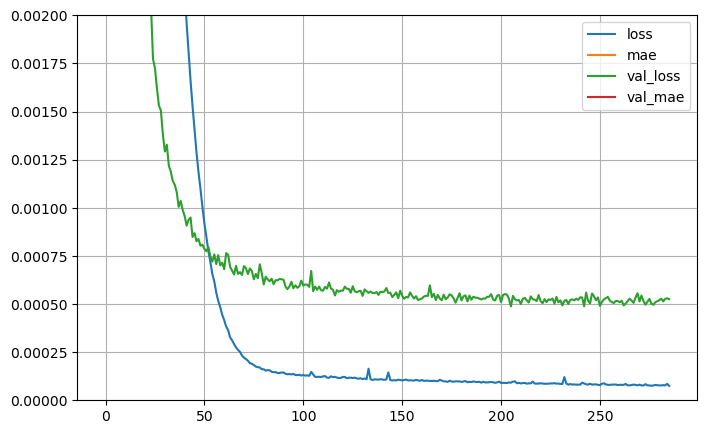

In [ ]:
pd.DataFrame(LSTM_history_cart.history).plot(figsize=(8, 5))
plt.grid(True)
#plt.gca().set_xlim(0, 1)
plt.gca().set_ylim(0, 2e-3)
plt.show()

# Comparación de estimaciones

**Estimación de Dataset Joint**

In [ ]:
#Estimación de Dataset Joint
#Uso el otro dataset joint

datos_2LRP_comp_joint = pd.read_csv(f'./2lpr_jointmovement_2024_12_01-18_04_07.csv',delimiter=',', encoding="utf-8", skipinitialspace=True)

t_ref_comp_joint = datos_2LRP_comp_joint.iloc[:,1].values

q1_ref_comp_joint = datos_2LRP_comp_joint.iloc[:,2].values
q2_ref_comp_joint = datos_2LRP_comp_joint.iloc[:,3].values

dq1_ref_comp_joint = datos_2LRP_comp_joint.iloc[:,4].values
dq2_ref_comp_joint = datos_2LRP_comp_joint.iloc[:,5].values

ddq1_ref_comp_joint = datos_2LRP_comp_joint.iloc[:,6].values
ddq2_ref_comp_joint = datos_2LRP_comp_joint.iloc[:,7].values

t1_ref_comp_joint = datos_2LRP_comp_joint.iloc[:,8].values
t2_ref_comp_joint = datos_2LRP_comp_joint.iloc[:,9].values
datos_2LRP_comp_joint.head()

,ID,Time,Theta_1,Theta_2,D_Theta_1,D_Theta_2,DD_Theta_1,DD_Theta_2,Torque_1,Torque_2
0,1,0.000,-1.926178,-1.430799,0.001258,0.004265,1.257762,4.265447,-2.000074,-0.890958
1,2,0.001,-1.926176,-1.430793,0.002516,0.008531,1.257762,4.265447,-1.999438,-0.888827
2,3,0.002,-1.926173,-1.430782,0.003773,0.012796,1.257762,4.265447,-1.998798,-0.886697
3,4,0.003,-1.926168,-1.430767,0.005031,0.017062,1.257762,4.265447,-1.998153,-0.884568
4,5,0.004,-1.926163,-1.430748,0.006289,0.021327,1.257762,4.265447,-1.997503,-0.882441


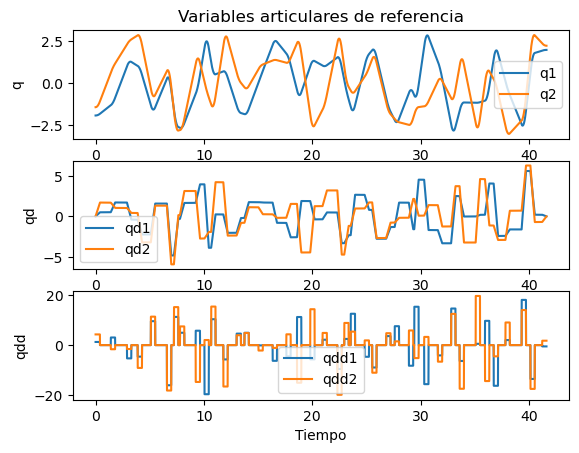

In [ ]:
num_links = 2


plt.subplot(3,1,1)
plt.plot(t_ref_comp_joint, q1_ref_comp_joint)
plt.plot(t_ref_comp_joint, q2_ref_comp_joint)
plt.legend(['q1', 'q2']);  plt.ylabel('q')
plt.title('Variables articulares de referencia')
plt.subplot(3,1,2)
plt.plot(t_ref_comp_joint, dq1_ref_comp_joint)
plt.plot(t_ref_comp_joint, dq2_ref_comp_joint)
plt.legend(['qd1', 'qd2']);  plt.ylabel('qd')
plt.subplot(3,1,3)
plt.plot(t_ref_comp_joint, ddq1_ref_comp_joint)
plt.plot(t_ref_comp_joint, ddq2_ref_comp_joint)
plt.legend(['qdd1', 'qdd2']); plt.xlabel('Tiempo'); plt.ylabel('qdd')
plt.show()

In [ ]:
inputs_ref_comp_joint = np.vstack((q1_ref_comp_joint,q2_ref_comp_joint,dq1_ref_comp_joint,dq2_ref_comp_joint,ddq1_ref_comp_joint,ddq2_ref_comp_joint)).T
outputs_ref_comp_joint = np.vstack((t1_ref_comp_joint,t2_ref_comp_joint)).T

In [ ]:
#Primero con FF NN entrenada con Cartesianas
X_test_scaled_FF_NN_comp_joint_c = scaler1_FF_cart.transform(inputs_ref_comp_joint)
tau_sim_FF_NN_comp_joint_c = scaler2_FF_cart.inverse_transform(FFNN_network_cart.predict(X_test_scaled_FF_NN_comp_joint_c))

  80/1301 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 1s 787us/step


In [ ]:
#Primero con FF NN entrenada con Joint
X_test_scaled_FF_NN_comp_joint_j = scaler1_SS.transform(inputs_ref_comp_joint)
tau_sim_FF_NN_comp_joint_j = scaler2_SS.inverse_transform(FFNN_SS_network.predict(X_test_scaled_FF_NN_comp_joint_j))

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 1s 586us/step


In [ ]:
#Con LSTM entrenada con Cartesianas
X_test_scaled_LSTM_comp_joint_c = scaler1_LSTM_cart.transform(inputs_ref_comp_joint)
X_test_windowed_LSTM_comp_joint_c, t_ref_LSTM_comp_joint_c = create_sequences_with_time(X_test_scaled_LSTM_comp_joint_c, t_ref_comp_joint)
X_test_windowed_LSTM_comp_joint_c
tau_sim_LSTM_comp_joint_c = scaler2_LSTM_cart.inverse_transform(LSTM_network_cart.predict(X_test_windowed_LSTM_comp_joint_c))
tau_sim_LSTM_comp_joint_c

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


array([[ 0.6891403 , -0.8254178 ],
       [ 0.6878335 , -0.8245203 ],
       [ 0.68651694, -0.82362086],
       ...,
       [ 0.31280243, -1.4443458 ],
       [ 0.31218708, -1.4436802 ],
       [ 0.31157303, -1.4430152 ]], dtype=float32)

In [ ]:
#Con LSTM entrenada con Joint
X_test_scaled_LSTM_comp_joint_j = scaler1_LSTM.transform(inputs_ref_comp_joint)
X_test_windowed_LSTM_comp_joint_j, t_ref_LSTM_comp_joint_j = create_sequences_with_time(X_test_scaled_LSTM_comp_joint_j, t_ref_comp_joint)
X_test_windowed_LSTM_comp_joint_j
tau_sim_LSTM_comp_joint_j = scaler2_LSTM.inverse_transform(LSTM_network.predict(X_test_windowed_LSTM_comp_joint_j))

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


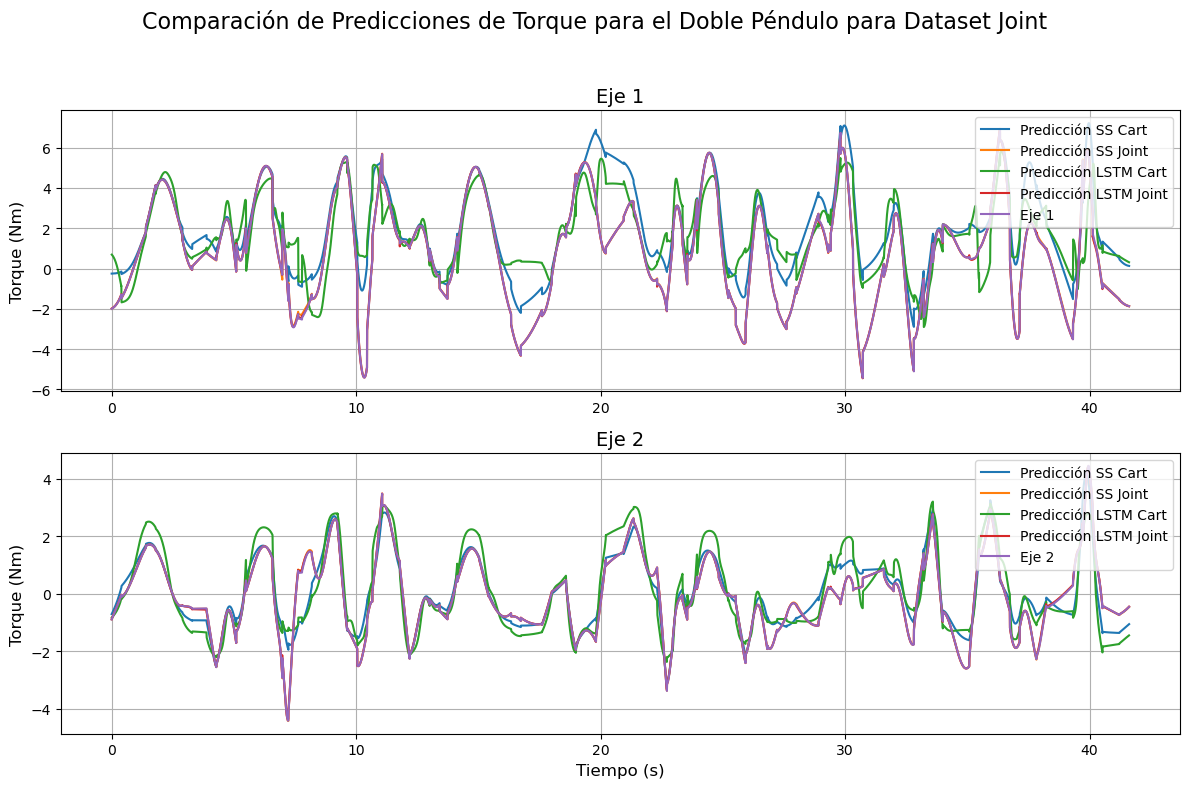

In [ ]:
# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 8))  # Cambia el tamaño según tus necesidades

# Agregar un título general
plt.suptitle("Comparación de Predicciones de Torque para el Doble Péndulo para Dataset Joint", fontsize=16)

# Graficar los resultados
for i in range(num_links):
    plt.subplot(num_links, 1, i + 1)
    
    # Graficar las diferentes predicciones y los valores reales
    plt.plot(t_ref_comp_joint,tau_sim_FF_NN_comp_joint_c[:,i], label='Predicción SS Cart')
    plt.plot(t_ref_comp_joint,tau_sim_FF_NN_comp_joint_j[:,i], label='Predicción SS Joint')
    plt.plot(t_ref_LSTM_comp_joint_c,tau_sim_LSTM_comp_joint_c[:,i], label='Predicción LSTM Cart')
    plt.plot(t_ref_LSTM_comp_joint_j,tau_sim_LSTM_comp_joint_j[:,i], label='Predicción LSTM Joint')
    plt.plot(t_ref_comp_joint,outputs_ref_comp_joint[:,i], label=f'Eje {i+1}')
    
    # Ajustar etiquetas y título del subplot
    plt.ylabel('Torque (Nm)', fontsize=12)
    plt.title(f'Eje {i+1}', fontsize=14)
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True)  # Añadir una cuadrícula para facilitar la lectura

# Etiqueta para el eje X
plt.xlabel('Tiempo (s)', fontsize=12)

# Ajustar los espacios entre subplots
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Dejar espacio para el título general

# Mostrar el gráfico
plt.show()

ValueError: operands could not be broadcast together with shapes (41609,) (41613,) 

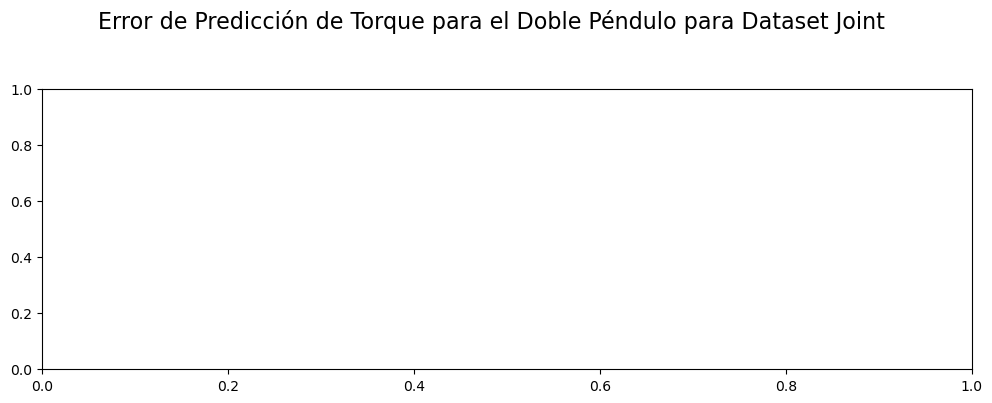

In [ ]:
# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 8))  # Cambia el tamaño según tus necesidades

# Agregar un título general
plt.suptitle("Error de Predicción de Torque para el Doble Péndulo para Dataset Joint", fontsize=16)

# Graficar los errores
for i in range(num_links):
    plt.subplot(num_links, 1, i + 1)
    
    # Calcular errores
    #error_SS_Cart_j = (tau_sim_FF_NN_comp_joint_c[:, i] - outputs_ref_comp_joint[:, i])
    #error_SS_Joint_j = (tau_sim_FF_NN_comp_joint_j[:, i] - outputs_ref_comp_joint[:, i])
    #error_LSTM_Cart_j = (tau_sim_LSTM_comp_joint_c[:, i] - outputs_ref_comp_joint[5:, i])
    #error_LSTM_Joint_j = (tau_sim_LSTM_comp_joint_j[:, i] - outputs_ref_comp_joint[5:, i])
    error_SS_Cart_j = np.sqrt((tau_sim_FF_NN_comp_joint_c[:, i] - outputs_ref_comp_joint[:, i])**2)
    error_SS_Joint_j = np.sqrt((tau_sim_FF_NN_comp_joint_j[:, i] - outputs_ref_comp_joint[:, i])**2)
    error_LSTM_Cart_j = np.sqrt((tau_sim_LSTM_comp_joint_c[:, i] - outputs_ref_comp_joint[5:, i])**2)
    error_LSTM_Joint_j = np.sqrt((tau_sim_LSTM_comp_joint_j[:, i] - outputs_ref_comp_joint[5:, i])**2)
    
    # Graficar los errores
    plt.plot(t_ref_comp_joint, error_SS_Cart_j, label='Error SS Cart')
    plt.plot(t_ref_comp_joint, error_SS_Joint_j, label='Error SS Joint')
    plt.plot(t_ref_LSTM_comp_joint_c, error_LSTM_Cart_j, label='Error LSTM Cart')
    plt.plot(t_ref_LSTM_comp_joint_j, error_LSTM_Joint_j, label='Error LSTM Joint')
    
    # Ajustar etiquetas y título del subplot
    plt.ylabel('Error (Nm)', fontsize=12)
    plt.title(f'Eje {i+1}', fontsize=14)
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True)  # Añadir una cuadrícula para facilitar la lectura

# Etiqueta para el eje X
plt.xlabel('Tiempo (s)', fontsize=12)

# Ajustar los espacios entre subplots
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Dejar espacio para el título general

# Mostrar el gráfico
plt.show()


**Estimación de Dataset Cartesiano**

In [ ]:
#Estimación de Dataset Cartesiano

datos_2LRP_comp_cart = pd.read_csv(f'./2lpr_cartesianmovement_2024_12_01-18_04_07.csv',delimiter=',', encoding="utf-8", skipinitialspace=True)

t_ref_comp_cart = datos_2LRP_comp_cart.iloc[:,1].values

q1_ref_comp_cart = datos_2LRP_comp_cart.iloc[:,2].values
q2_ref_comp_cart = datos_2LRP_comp_cart.iloc[:,3].values

dq1_ref_comp_cart = datos_2LRP_comp_cart.iloc[:,4].values
dq2_ref_comp_cart = datos_2LRP_comp_cart.iloc[:,5].values

ddq1_ref_comp_cart = datos_2LRP_comp_cart.iloc[:,6].values
ddq2_ref_comp_cart = datos_2LRP_comp_cart.iloc[:,7].values

t1_ref_comp_cart = datos_2LRP_comp_cart.iloc[:,8].values
t2_ref_comp_cart = datos_2LRP_comp_cart.iloc[:,9].values
datos_2LRP_comp_cart.head()

,ID,Time,Theta_1,Theta_2,D_Theta_1,D_Theta_2,DD_Theta_1,DD_Theta_2,Torque_1,Torque_2
0,1,0.000,-1.174887,1.043499,-0.006224,0.011834,-4.149315,7.888932,2.095864,0.976848
1,2,0.001,-1.174893,1.043511,-0.010373,0.019723,-4.149118,7.888525,2.093779,0.980795
2,3,0.002,-1.174903,1.043531,-0.014523,0.027611,-4.148843,7.887955,2.091685,0.984743
3,4,0.003,-1.174918,1.043558,-0.018671,0.035499,-4.148489,7.887223,2.089583,0.988693
4,5,0.004,-1.174936,1.043594,-0.022820,0.043386,-4.148057,7.886328,2.087471,0.992643


: 

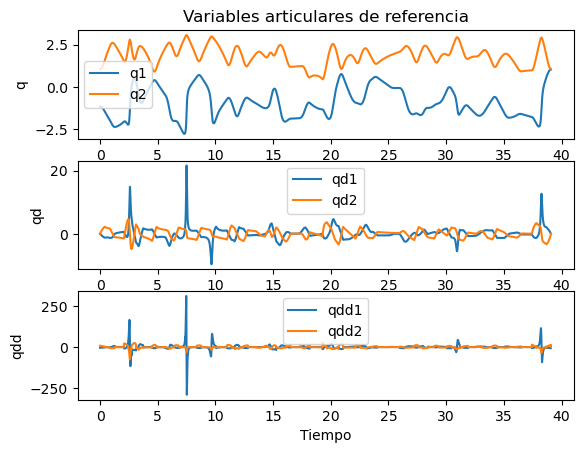

: 

In [ ]:
num_links = 2


plt.subplot(3,1,1)
plt.plot(t_ref_comp_cart, q1_ref_comp_cart)
plt.plot(t_ref_comp_cart, q2_ref_comp_cart)
plt.legend(['q1', 'q2']);  plt.ylabel('q')
plt.title('Variables articulares de referencia')
plt.subplot(3,1,2)
plt.plot(t_ref_comp_cart, dq1_ref_comp_cart)
plt.plot(t_ref_comp_cart, dq2_ref_comp_cart)
plt.legend(['qd1', 'qd2']);  plt.ylabel('qd')
plt.subplot(3,1,3)
plt.plot(t_ref_comp_cart, ddq1_ref_comp_cart)
plt.plot(t_ref_comp_cart, ddq2_ref_comp_cart)
plt.legend(['qdd1', 'qdd2']); plt.xlabel('Tiempo'); plt.ylabel('qdd')
plt.show()

In [ ]:
inputs_ref_comp_cart = np.vstack((q1_ref_comp_cart,q2_ref_comp_cart,dq1_ref_comp_cart,dq2_ref_comp_cart,ddq1_ref_comp_cart,ddq2_ref_comp_cart)).T
outputs_ref_comp_cart = np.vstack((t1_ref_comp_cart,t2_ref_comp_cart)).T

: 

In [ ]:
#Primero con FF NN entrenada con Cart

X_test_scaled_FF_NN_comp_cart_c = scaler1_FF_cart.transform(inputs_ref_comp_cart)
tau_sim_FF_NN_comp_cart_c = scaler2_FF_cart.inverse_transform(FFNN_network_cart.predict(X_test_scaled_FF_NN_comp_cart_c))

1222/1222 [==============================] - 1s 984us/step


: 

In [ ]:
#Primero con FF NN entrenada con Joint

X_test_scaled_FF_NN_comp_cart_j = scaler1_SS.transform(inputs_ref_comp_cart)
tau_sim_FF_NN_comp_cart_j = scaler2_SS.inverse_transform(FFNN_SS_network.predict(X_test_scaled_FF_NN_comp_cart_j))

1222/1222 [==============================] - 1s 1ms/step


: 

In [ ]:
#Con LSTM entrenada con Cart
X_test_scaled_LSTM_comp_cart_c = scaler1_LSTM_cart.transform(inputs_ref_comp_cart)
X_test_windowed_LSTM_comp_cart_c, t_ref_LSTM_comp_cart_c = create_sequences_with_time(X_test_scaled_LSTM_comp_cart_c, t_ref_comp_cart)
X_test_windowed_LSTM_comp_cart_c
tau_sim_LSTM_comp_cart_c = scaler2_LSTM_cart.inverse_transform(LSTM_network_cart.predict(X_test_windowed_LSTM_comp_cart_c))

1222/1222 [==============================] - 4s 3ms/step


: 

In [ ]:
#Con LSTM entrenada con Joint
X_test_scaled_LSTM_comp_cart_j = scaler1_LSTM.transform(inputs_ref_comp_cart)
X_test_windowed_LSTM_comp_cart_j, t_ref_LSTM_comp_cart_j = create_sequences_with_time(X_test_scaled_LSTM_comp_cart_j, t_ref_comp_cart)
X_test_windowed_LSTM_comp_cart_j
tau_sim_LSTM_comp_cart_j = scaler2_LSTM.inverse_transform(LSTM_network.predict(X_test_windowed_LSTM_comp_cart_j))

1222/1222 [==============================] - 4s 3ms/step


: 

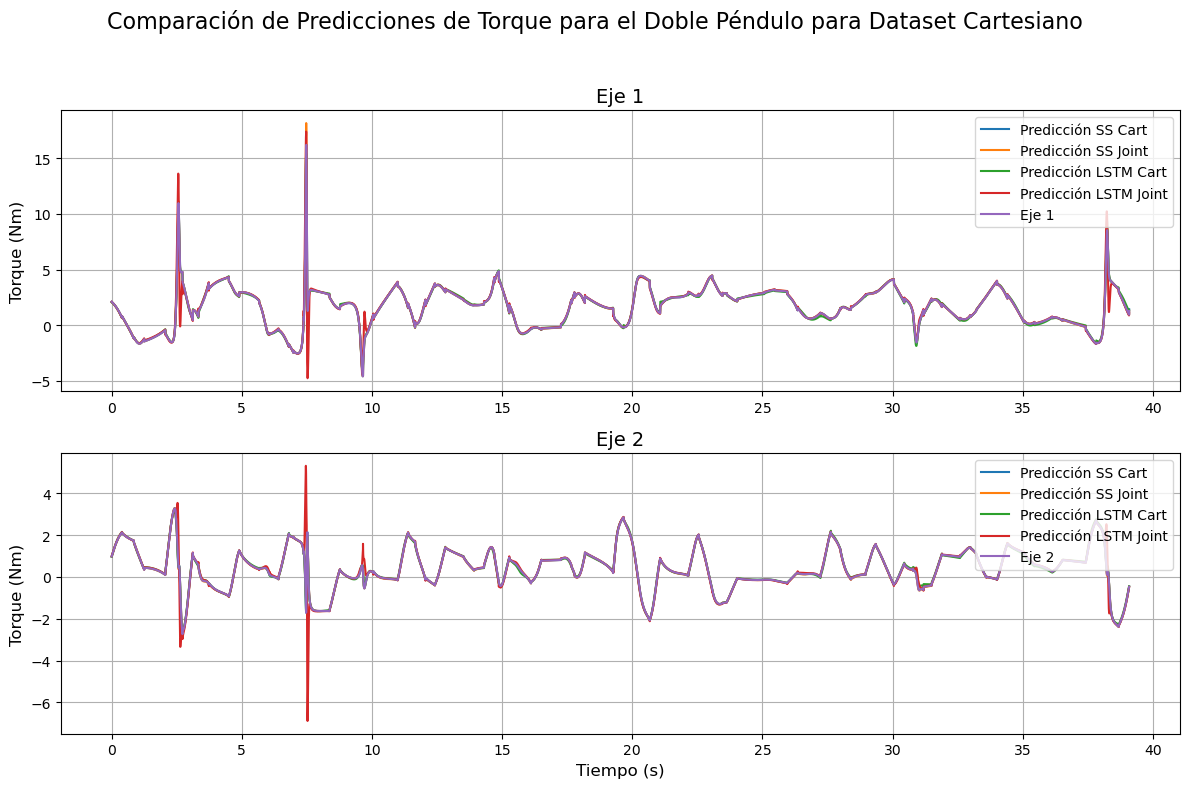

: 

In [ ]:
# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 8))  # Cambia el tamaño según tus necesidades

# Agregar un título general
plt.suptitle("Comparación de Predicciones de Torque para el Doble Péndulo para Dataset Cartesiano", fontsize=16)

# Graficar los resultados
for i in range(num_links):
    plt.subplot(num_links, 1, i + 1)
    
    # Graficar las diferentes predicciones y los valores reales
    plt.plot(t_ref_comp_cart, tau_sim_FF_NN_comp_cart_c[:, i], label='Predicción SS Cart')
    plt.plot(t_ref_comp_cart, tau_sim_FF_NN_comp_cart_j[:, i], label='Predicción SS Joint')
    plt.plot(t_ref_LSTM_comp_cart_c, tau_sim_LSTM_comp_cart_c[:, i], label='Predicción LSTM Cart')
    plt.plot(t_ref_LSTM_comp_cart_j, tau_sim_LSTM_comp_cart_j[:, i], label='Predicción LSTM Joint')
    plt.plot(t_ref_comp_cart, outputs_ref_comp_cart[:, i], label=f'Eje {i+1}')
    
    # Ajustar etiquetas y título del subplot
    plt.ylabel('Torque (Nm)', fontsize=12)
    plt.title(f'Eje {i+1}', fontsize=14)
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True)  # Añadir una cuadrícula para facilitar la lectura

# Etiqueta para el eje X
plt.xlabel('Tiempo (s)', fontsize=12)

# Ajustar los espacios entre subplots
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Dejar espacio para el título general

# Mostrar el gráfico
plt.show()


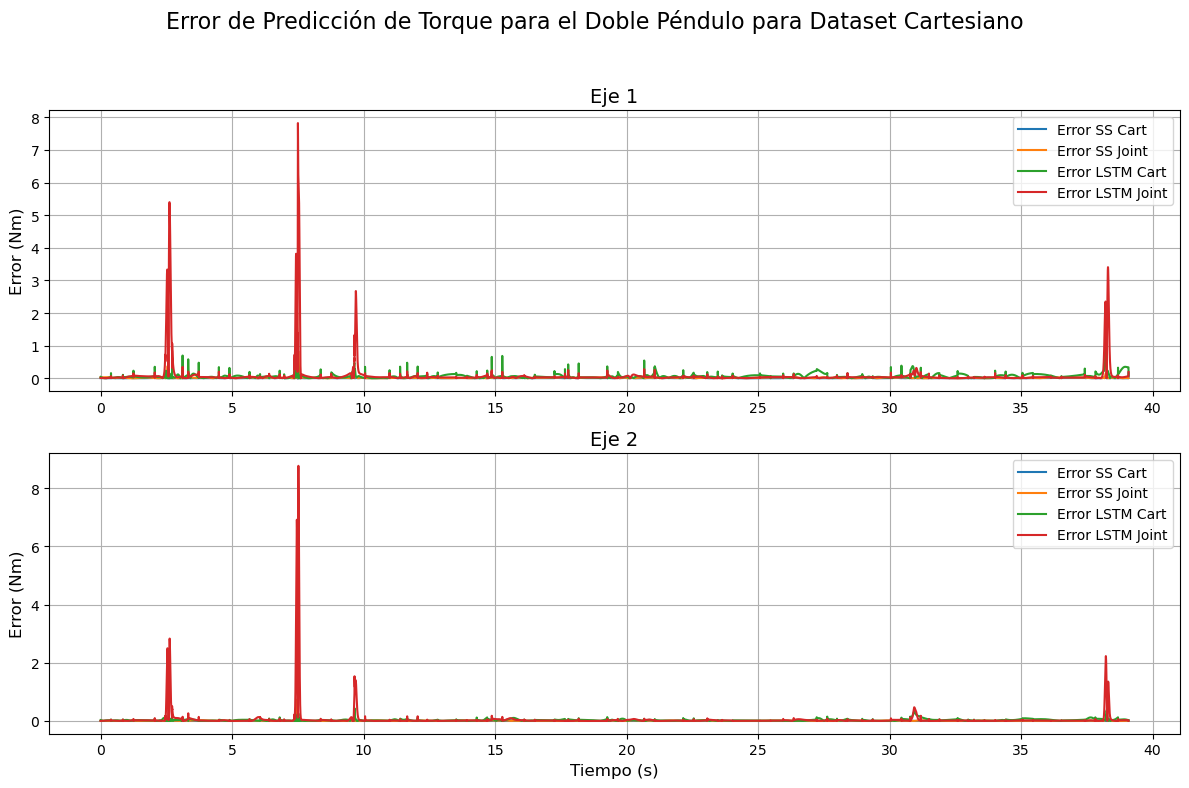

: 

In [ ]:
# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 8))  # Cambia el tamaño según tus necesidades

# Agregar un título general
plt.suptitle("Error de Predicción de Torque para el Doble Péndulo para Dataset Cartesiano", fontsize=16)

# Graficar los errores
for i in range(num_links):
    plt.subplot(num_links, 1, i + 1)
    
    # Calcular errores
    #error_SS_Cart_c = tau_sim_FF_NN_comp_cart_c[:, i] - outputs_ref_comp_cart[:, i]
    #error_SS_Joint_c = tau_sim_FF_NN_comp_cart_j[:, i] - outputs_ref_comp_cart[:, i]
    #error_LSTM_Cart_c = tau_sim_LSTM_comp_cart_c[:, i] - outputs_ref_comp_cart[5:, i]
    #error_LSTM_Joint_c = tau_sim_LSTM_comp_cart_j[:, i] - outputs_ref_comp_cart[5:, i]

    error_SS_Cart_c = np.sqrt((tau_sim_FF_NN_comp_cart_c[:, i] - outputs_ref_comp_cart[:, i])**2)
    error_SS_Joint_c = np.sqrt((tau_sim_FF_NN_comp_cart_j[:, i] - outputs_ref_comp_cart[:, i])**2)
    error_LSTM_Cart_c = np.sqrt((tau_sim_LSTM_comp_cart_c[:, i] - outputs_ref_comp_cart[5:, i])**2)
    error_LSTM_Joint_c = np.sqrt((tau_sim_LSTM_comp_cart_j[:, i] - outputs_ref_comp_cart[5:, i])**2)

    # Graficar los errores
    plt.plot(t_ref_comp_cart, error_SS_Cart_c, label='Error SS Cart')
    plt.plot(t_ref_comp_cart, error_SS_Joint_c, label='Error SS Joint')
    plt.plot(t_ref_LSTM_comp_cart_c, error_LSTM_Cart_c, label='Error LSTM Cart')
    plt.plot(t_ref_LSTM_comp_cart_j, error_LSTM_Joint_c, label='Error LSTM Joint')
    
    # Ajustar etiquetas y título del subplot
    plt.ylabel('Error (Nm)', fontsize=12)
    plt.title(f'Eje {i+1}', fontsize=14)
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True)  # Añadir una cuadrícula para facilitar la lectura

# Etiqueta para el eje X
plt.xlabel('Tiempo (s)', fontsize=12)

# Ajustar los espacios entre subplots
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Dejar espacio para el título general

# Mostrar el gráfico
plt.show()
